In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2 

In [1]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

In [8]:
def plot_pnl(pnl: pl.DataFrame, pnlni: pl.DataFrame):
    # Plot
    fig = plt.figure(figsize=(10, 6))
    plt.plot(
        pnl["lag_sec"] / 60,
        pnl["alpha_tickreturn_cov"],
        marker="o",
        ms=4,
        mec="k",
        lw=1.5,
        label="EMA Impact"
    )
    plt.plot(
        pnlni["lag_sec"] / 60,
        pnlni["alpha_tickreturn_cov"],
        marker="o",
        ms=4,
        mec="k",
        lw=1.5,
        label="No Impact"
    )
    
    plt.legend()
    plt.xlabel("Horizon (minutes)")
    plt.ylabel("ticks")
    plt.title(
        r"$\mathbb{E}\left[\alpha_t \cdot \left(P_{t+\Delta t} - P_t\right)\right] \text{ vs } \Delta t$ (With Races)"
    )
    plt.axhline(0, color="gray", linestyle="--", lw=0.8)
    plt.grid(True, alpha=0.3)
    plt.show()
    return fig    

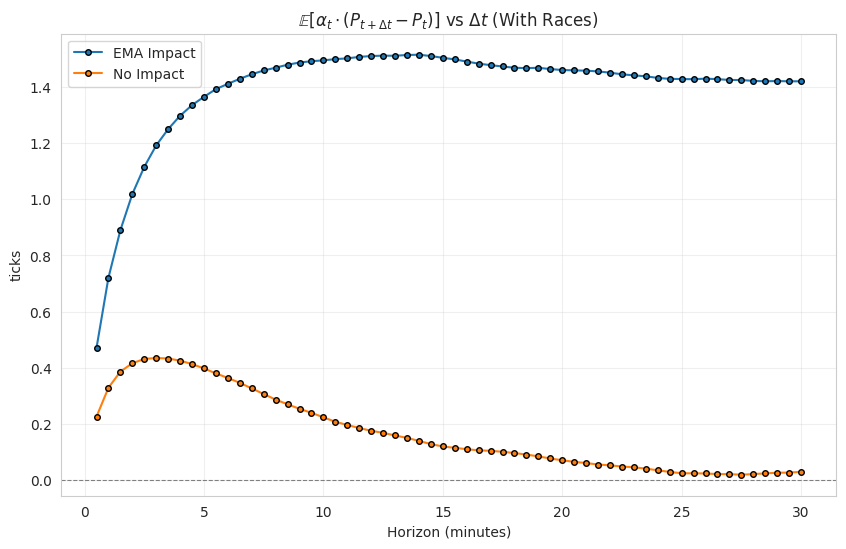

In [9]:
pnl = pl.read_csv("/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/result_alpha_ema_impact_k1.0_race_pnl.csv")
pnlni = pl.read_csv("../data/results/PFE/result_alpha_no_impact_k1.0_race_pnl.csv")

fig = plot_pnl(pnl, pnlni)

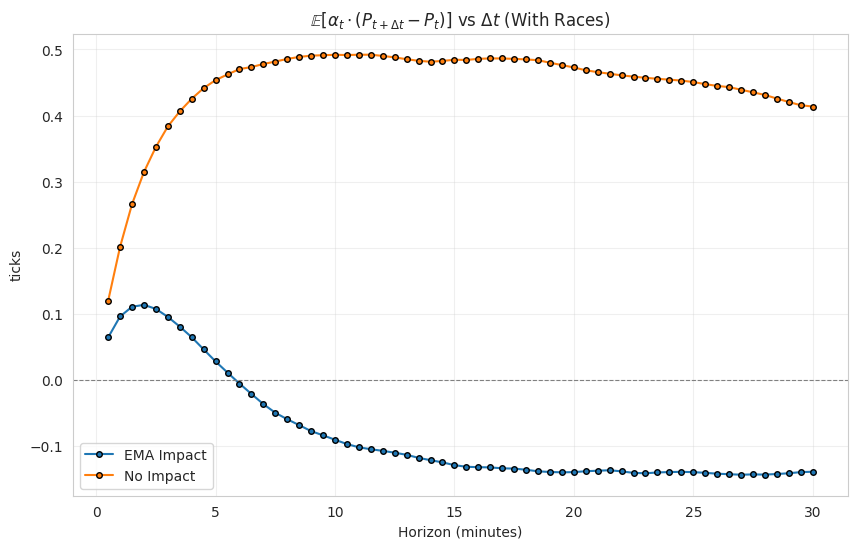

In [13]:
pnl = pl.read_csv("/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/result_alpha_ema_impact_k1.0_norace_pnl.csv")
pnlni = pl.read_csv("../data/results/PFE/result_alpha_no_impact_k1.0_norace_pnl.csv")

fig = plot_pnl(pnl, pnlni)

In [51]:
df = pl.read_parquet("/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/result_alpha_ema_impact_k1.0_race.parquet")

In [52]:
# Plot 2: ACF
timestamps = df["timestamp"].to_numpy()
alpha = df["alpha"].to_numpy()
alpha = alpha - alpha.mean()

lag_minutes = np.arange(1, 21)
lags_ns = lag_minutes * 60 * 1e9

acf = []
for lag_ns in lags_ns:
    future_idx = np.searchsorted(timestamps, timestamps + lag_ns)
    valid = future_idx < len(timestamps)
    num = (alpha[valid] * alpha[future_idx[valid]]).mean()
    denom = (alpha**2).mean()
    acf.append(num / denom)

acf = np.array(acf)
acf_theo = np.exp(-0.15 * lag_minutes)

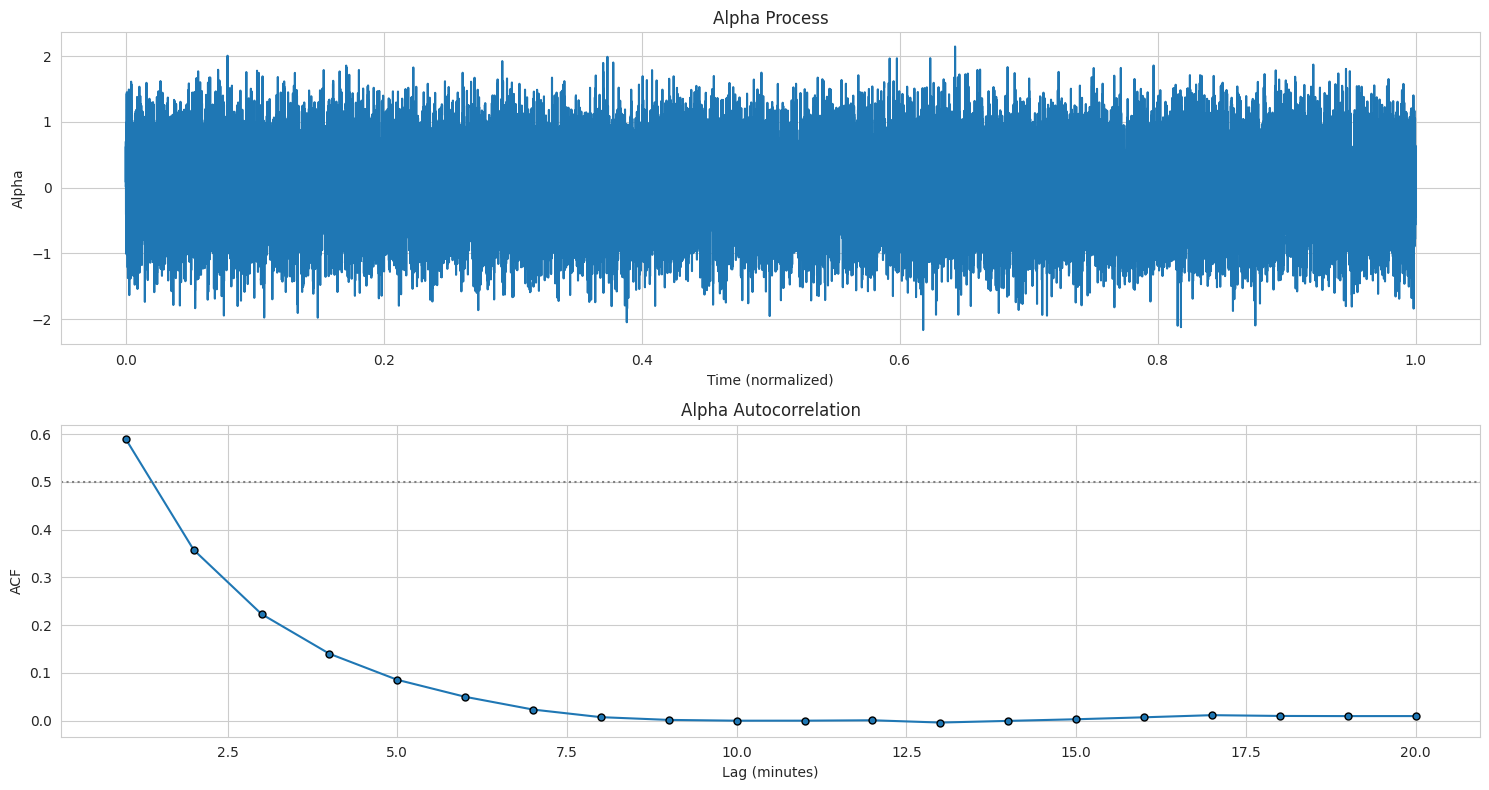

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Alpha time series
df_ = df[::100]
ax1.plot(df_["timestamp"] / df_["timestamp"].max(), df_["alpha"])
ax1.set_xlabel("Time (normalized)")
ax1.set_ylabel("Alpha")
ax1.set_title("Alpha Process")

ax2.plot(lag_minutes, acf, marker="o", ms=5, mec="k", lw=1.5)
ax2.axhline(0.5, color="gray", linestyle=":")
ax2.set_xlabel("Lag (minutes)")
ax2.set_ylabel("ACF")
ax2.set_title(r"Alpha Autocorrelation")

plt.tight_layout()
plt.show()

In [54]:
# Plot 2: ACF
timestamps = df["timestamp"].to_numpy()
alpha = df["bias"].to_numpy()
alpha = alpha - alpha.mean()

lag_minutes = np.arange(1, 21)
lags_ns = lag_minutes * 60 * 1e9

acf = []
for lag_ns in lags_ns:
    future_idx = np.searchsorted(timestamps, timestamps + lag_ns)
    valid = future_idx < len(timestamps)
    num = (alpha[valid] * alpha[future_idx[valid]]).mean()
    denom = (alpha**2).mean()
    acf.append(num / denom)

acf = np.array(acf)
acf_theo = np.exp(-0.15 * lag_minutes)

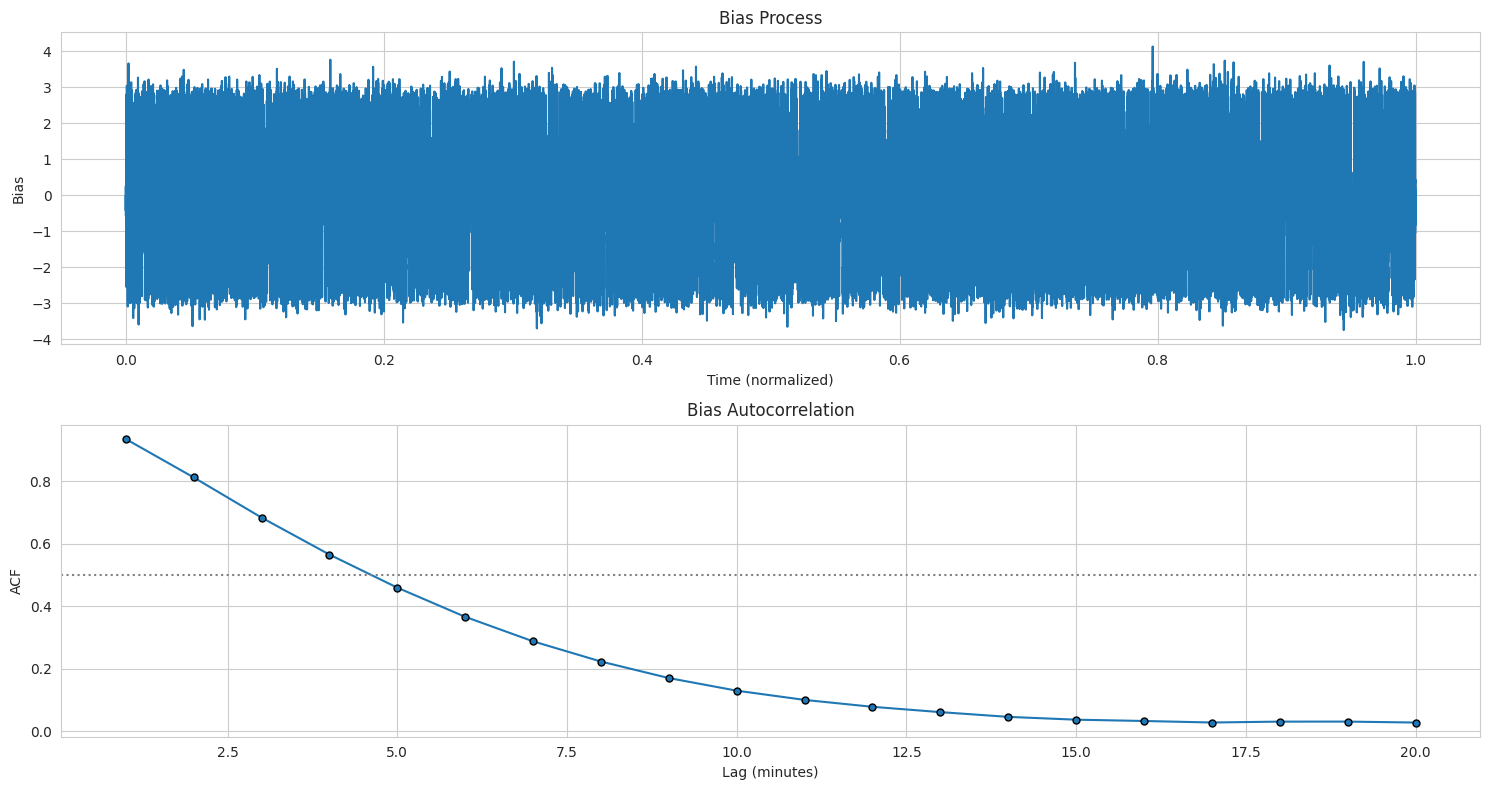

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Alpha time series
df_ = df[::100]
ax1.plot(df_["timestamp"] / df_["timestamp"].max(), df_["bias"])
ax1.set_xlabel("Time (normalized)")
ax1.set_ylabel("Bias")
ax1.set_title("Bias Process")

ax2.plot(lag_minutes, acf, marker="o", ms=5, mec="k", lw=1.5)
ax2.axhline(0.5, color="gray", linestyle=":")
ax2.set_xlabel("Lag (minutes)")
ax2.set_ylabel("ACF")
ax2.set_title(r"Bias Autocorrelation")

plt.tight_layout()
plt.show()